# 1D Burgers Data-Driven Parameter Discovery PINN

*Last edited: 2024-04-26*  
*Created: 2023-11-30*

Based on: <https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)> .

Terms:

* **Discorery** is when the network is able to identify the underlying partial differential equation.

* **Continous time** models take into account the exact time interval between measurements.

In the train phase the neural network estimates a solution $u(t,x)$.
The function employed by the PINN, $f(t,x)$ (Equation 2), is derived from the known Burgers' equation, and allows to calculate the loss function.
The parameters of the differential operator that we want to obtain are transformed into PINN parameters.
In the following equations, the differential operator parameter $\lambda_1$ (or $u$) is the speed of fluid at the indicated spatial and temporal coordinates, the differential operator parameter $\lambda_2$ (or $\nu$) is the kinematic viscosity of fluid, and the subscripts denote partial differentiation in time and space, respectively, as
$u_t$ (which denotes $\frac{du}{dt}$), 
$u_x$ (which denotes $\frac{du}{dx}$), and 
$u_{xx}$ (which denotes $\frac{d^2u}{dx^2}$).

$$
u_t + \lambda_1 u_x - \lambda_2 u_{xx} = 0, \quad x \in [-1,1], \ t \in [0, 1]  \tag{1}
$$

The Burgers' equation is employed to evaluate the error $f$ of the solution $u(t,x)$ estimated by the PINN, as shown in Equation 2.

$$
f := u_t + \lambda_1 u_x - \lambda_2 u_{xx} \tag{2}
$$

## Libraries & Setup

In [11]:
%env TF_CPP_MIN_LOG_LEVEL=3
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Prevent tensorflow from allocating all GPU memory
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)
tf.compat.v1.set_random_seed(1234)  # Reproducibility
print(tf.__version__)

from scipy.interpolate import griddata
import scipy.io

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

my_rc_param = {'text.usetex': False}
plt.rcParams.update(my_rc_param)

import time
import os
import numpy as np

np.random.seed(1234)  # Reproducibility

env: TF_CPP_MIN_LOG_LEVEL=3
1.15.0


## Plotting module

In [12]:
def figsize(scale, nplots=1):
    fig_width_pt = 390.0  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch

    # Aesthetic ratio (you could change this)
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0

    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = nplots * fig_width * golden_mean  # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size


def newfig(width, nplots=1):
    # fig = plt.figure(figsize=figsize(width, nplots)) #latex
    fig = plt.figure()
    ax = fig.add_subplot(111)
    return fig, ax

## PINN

L-BFGS-B parameters (<https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html>):
- *maxiter* - Maximum number of iterations.
- *maxfun* - maximum number of function evaluations. Note that this function may violate the limit because of evaluating gradients by numerical differentiation.
- *maxcor* - the maximum number of variable metric corrections used to define the limited memory matrix. (The limited memory BFGS method does not store the full hessian but uses this many terms in an approximation to it.)
- *ftol* - the iteration stops when $(f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1}$ <= ftol.
- *maxls* - maximum number of line search steps (per iteration). Default is 20.

In [13]:
class PhysicsInformedNN:

    def __init__(self, X, u, layers, lb, ub):
        self.lb = lb
        self.ub = ub
        self.x = X[:, 0:1]
        self.t = X[:, 1:2]
        self.u = u
        self.layers = layers
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([-6.0], dtype=tf.float32)
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        self.loss = (tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) +
                     tf.reduce_mean(tf.square(self.f_pred)))

        # L-BFGS-B optimizer
        # https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(
            self.loss,
            method='L-BFGS-B',
            options={
                'maxiter': 50000,
                'maxfun': 50000,
                'maxcor': 50,
                'maxls': 50,
                # The smallest representable number such that 1.0 + eps != 1.0
                'ftol': 1.0 * np.finfo(float).eps
            })

        # Adam optimizer
        #self.optimizer_Adam = tf.train.AdamOptimizer()
        #self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        # TF startup
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim],
                                               stddev=xavier_stddev),
                           dtype=tf.float32)

    # structure definition
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32),
                            dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases)
        return u

    def net_f(self, x, t):
        lambda_1 = self.lambda_1
        lambda_2 = tf.exp(self.lambda_2)
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f

    # train definition
    # def callback(self, loss, lambda_1, lambda_2):
    #     print('Loss: %e, Lambda_1: %.5f, Lambda_2: %.5f'
    #           % (loss, lambda_1, np.exp(lambda_2)))

    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}

        # print("=== start Adam optimizer ===")
        # for it in range(nIter):
        #     self.sess.run(self.train_op_Adam, tf_dict)
        #     if it % 100 == 0:
        #         loss_value = self.sess.run(self.loss, tf_dict)
        #         lambda_1_value = self.sess.run(self.lambda_1)
        #         lambda_2_value = np.exp(self.sess.run(self.lambda_2))
        #         print('Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f'
        #             % (loss_value, lambda_1_value, lambda_2_value))

        print("L-BFGS-B optimizer run.")
        self.optimizer.minimize(
            self.sess,
            feed_dict=tf_dict,
            # fetches=[self.loss, self.lambda_1, self.lambda_2],
            # loss_callback=self.callback
        )

    # prediction definition
    def predict(self, X_star):
        tf_dict = {self.x_tf: X_star[:, 0:1], self.t_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        return u_star, f_star

<hr style="height:50px;border-width:0;background-color:green">

## Problem 01

viscosity = 0.01/np.pi

<hr style="height:10px;border-width:0;background-color:blue">

### 128x64

In [41]:
nu = 0.01/np.pi  # viscosity
N_u = 2000  # nro of CPs
layers = [2, 20, 20, 20, 1]  # achitecture
data = np.load('../data/burgers128x64.npz')

## Main

In [42]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

In [43]:
x.size, t.size, Exact.size

(128, 64, 8192)

## Model

In [44]:
%%time
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1

:0
Reshape_51/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_52/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_53/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_54/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_55/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_56/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_57/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_58/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_59/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_60/shape: (Const): /job:localhost/

## Train

Computing-intensive part

In [45]:
%%time
model.train(0)

L-BFGS-B optimizer run.
CPU times: user 1min 13s, sys: 4.58 s, total: 1min 18s
Wall time: 39.7 s


## Predict

In [47]:
%%time
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

CPU times: user 284 ms, sys: 48.1 ms, total: 333 ms
Wall time: 283 ms


### Show the identified PDE

In [48]:
lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

In [49]:
print(r'Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0')
print(r'Identified PDE: ',
      r'u_t + %.5f u u_x - %.7f u_{xx} = 0' % (lambda_1_value, lambda_2_value))

Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0
Identified PDE:  u_t + 0.99912 u u_x - 0.0033735 u_{xx} = 0


## Error

- Uses the L2 norm (Euclidean distance)
- errou_u = distance error relative to distance

In [50]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100
print('Error u: %e' % (error_u))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))

Error u: 4.367701e-03
Error l1: 0.08816%
Error l2: 5.98103%


## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


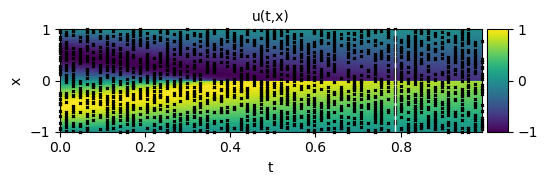

In [51]:
fig, ax = newfig(1.2, 1.2)
ax.axis('off')

# u(t,x)

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06,
           bottom=1 - 1.0 / 3.0 + 0.06,
           left=0.15,
           right=0.85,
           wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T,
              interpolation='nearest',
              cmap='viridis',
              extent=[t.min(), t.max(), x.min(),
                      x.max()],
              origin='lower',
              aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1],
        X_u_train[:, 0],
        'kx',
        #label='Data (%d points)' % (u_train.shape[0]),
        markersize=2,
        clip_on=False)

line = np.linspace(x.min(), x.max(), 2)[:, None]
#ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
#ax.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.0, -0.125),
          ncol=5,
          frameon=False)
ax.set_title('u(t,x)', fontsize=10)

plt.show()

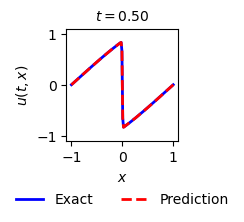

In [52]:
# u(t,x) slices

gs1 = gridspec.GridSpec(1, 1)
gs1.update(top=1 - 1.0 / 3.0 - 0.1,
           bottom=1.0 - 2.0 / 3.0,
           left=0.1,
           right=0.9,
           wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[50, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=10)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.35),
          ncol=5,
          frameon=False)

plt.show()

<hr style="height:10px;border-width:0;background-color:blue">

### 256x128

In [53]:
nu = 0.01/np.pi  # viscosity
N_u = 2000  # nro of CPs
layers = [2, 20, 20, 20, 1]  # achitecture
data = np.load('../data/burgers256x128.npz')

## Main

In [54]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

In [55]:
x.size, t.size, Exact.size

(256, 128, 32768)

## Model

In [56]:
%%time
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1

(Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_166/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_167/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_168/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_169/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_170/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_171/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_172/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_173/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_174/shape: (Const): /job:localhost/replica:0/ta

## Train

Computing-intensive part

In [57]:
%%time
model.train(0)

L-BFGS-B optimizer run.
CPU times: user 3min 9s, sys: 11.1 s, total: 3min 20s
Wall time: 1min 46s


## Predict

In [58]:
%%time
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

CPU times: user 1.02 s, sys: 177 ms, total: 1.19 s
Wall time: 956 ms


### Show the identified PDE

In [59]:
lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

In [60]:
print(r'Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0')
print(r'Identified PDE: ',
      r'u_t + %.5f u u_x - %.7f u_{xx} = 0' % (lambda_1_value, lambda_2_value))

Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0
Identified PDE:  u_t + 0.99942 u u_x - 0.0031779 u_{xx} = 0


## Error

- Uses the L2 norm (Euclidean distance)
- errou_u = distance error relative to distance

In [61]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100
print('Error u: %e' % (error_u))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))

Error u: 1.987021e-03
Error l1: 0.05822%
Error l2: 0.16325%


## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


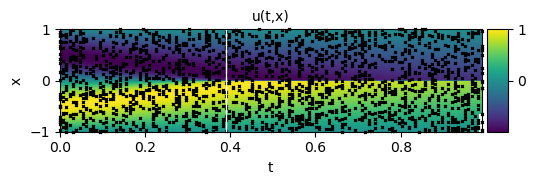

In [62]:
fig, ax = newfig(1.2, 1.2)
ax.axis('off')

# u(t,x)

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06,
           bottom=1 - 1.0 / 3.0 + 0.06,
           left=0.15,
           right=0.85,
           wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T,
              interpolation='nearest',
              cmap='viridis',
              extent=[t.min(), t.max(), x.min(),
                      x.max()],
              origin='lower',
              aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1],
        X_u_train[:, 0],
        'kx',
        #label='Data (%d points)' % (u_train.shape[0]),
        markersize=2,
        clip_on=False)

line = np.linspace(x.min(), x.max(), 2)[:, None]
#ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
#ax.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.0, -0.125),
          ncol=5,
          frameon=False)
ax.set_title('u(t,x)', fontsize=10)

plt.show()

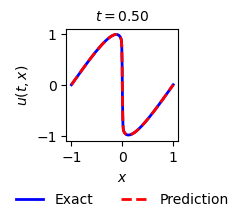

In [63]:
# u(t,x) slices

gs1 = gridspec.GridSpec(1, 1)
gs1.update(top=1 - 1.0 / 3.0 - 0.1,
           bottom=1.0 - 2.0 / 3.0,
           left=0.1,
           right=0.9,
           wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[50, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=10)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.35),
          ncol=5,
          frameon=False)

plt.show()

<hr style="height:10px;border-width:0;background-color:blue">

### 512x256

In [64]:
nu = 0.01/np.pi  # viscosity
N_u = 2000  # nro of CPs
layers = [2, 20, 20, 20, 1]  # achitecture
data = np.load('../data/burgers512x256.npz')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Main

In [65]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

In [66]:
x.size, t.size, Exact.size

(512, 256, 131072)

## Model

In [67]:
%%time
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1

:0/task:0/device:GPU:0
Reshape_276/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_277/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_278/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_279/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_280/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_281/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_282/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_283/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_284/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_285/s

## Train

Computing-intensive part

In [68]:
%%time
model.train(0)

L-BFGS-B optimizer run.
CPU times: user 2min 2s, sys: 6.78 s, total: 2min 9s
Wall time: 1min 8s


## Predict

In [69]:
%%time
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

CPU times: user 3.24 s, sys: 637 ms, total: 3.87 s
Wall time: 2.81 s


### Show the identified PDE

In [70]:
lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

In [71]:
print(r'Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0')
print(r'Identified PDE: ',
      r'u_t + %.5f u u_x - %.7f u_{xx} = 0' % (lambda_1_value, lambda_2_value))

Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0
Identified PDE:  u_t + 0.99850 u u_x - 0.0031403 u_{xx} = 0


## Error

- Uses the L2 norm (Euclidean distance)
- errou_u = distance error relative to distance

In [72]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100
print('Error u: %e' % (error_u))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))

Error u: 2.902435e-03
Error l1: 0.15041%
Error l2: 1.34611%


## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


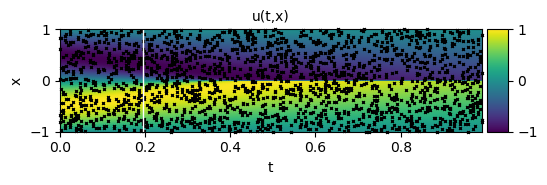

In [73]:
fig, ax = newfig(1.2, 1.2)
ax.axis('off')

# u(t,x)

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06,
           bottom=1 - 1.0 / 3.0 + 0.06,
           left=0.15,
           right=0.85,
           wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T,
              interpolation='nearest',
              cmap='viridis',
              extent=[t.min(), t.max(), x.min(),
                      x.max()],
              origin='lower',
              aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1],
        X_u_train[:, 0],
        'kx',
        #label='Data (%d points)' % (u_train.shape[0]),
        markersize=2,
        clip_on=False)

line = np.linspace(x.min(), x.max(), 2)[:, None]
#ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
#ax.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.0, -0.125),
          ncol=5,
          frameon=False)
ax.set_title('u(t,x)', fontsize=10)

plt.show()

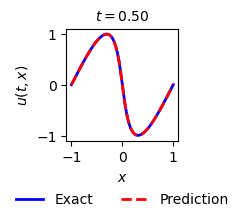

In [74]:
# u(t,x) slices

gs1 = gridspec.GridSpec(1, 1)
gs1.update(top=1 - 1.0 / 3.0 - 0.1,
           bottom=1.0 - 2.0 / 3.0,
           left=0.1,
           right=0.9,
           wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[50, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=10)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.35),
          ncol=5,
          frameon=False)

plt.show()

<hr style="height:50px;border-width:0;background-color:green">

## Problem 02

viscosity = 0.1/np.pi

<hr style="height:10px;border-width:0;background-color:blue">

### 128x64

In [76]:
nu = 0.1/np.pi  # viscosity
N_u = 2000  # nro of CPs
layers = [2, 20, 20, 20, 1]  # achitecture
# datafile = '../data/burgers_shock.mat'
data = np.load('../data/burgers128x64-02.npz')

## Main

In [77]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

## Model

In [78]:
%%time
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1

st/replica:0/task:0/device:GPU:0
Reshape_406/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_407/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_408/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_409/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_410/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_411/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_412/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_413/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_414/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Res

## Train

Computing-intensive part

In [79]:
%%time
model.train(0)

L-BFGS-B optimizer run.
CPU times: user 54.3 s, sys: 3 s, total: 57.3 s
Wall time: 32.4 s


## Predict

In [80]:
%%time
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

CPU times: user 929 ms, sys: 678 ms, total: 1.61 s
Wall time: 460 ms


### Show the identified PDE

In [81]:
lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

In [82]:
print(r'Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0')
print(r'Identified PDE: ',
      r'u_t + %.5f u u_x - %.7f u_{xx} = 0' % (lambda_1_value, lambda_2_value))

Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0
Identified PDE:  u_t + 0.99928 u u_x - 0.0318582 u_{xx} = 0


## Error

- Uses the L2 norm (Euclidean distance)
- errou_u = distance error relative to distance

In [83]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100
print('Error u: %e' % (error_u))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))

Error u: 1.407618e-03
Error l1: 0.07203%
Error l2: 0.08542%


## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


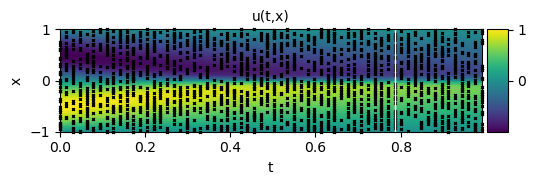

In [84]:
fig, ax = newfig(1.2, 1.2)
ax.axis('off')

# u(t,x)

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06,
           bottom=1 - 1.0 / 3.0 + 0.06,
           left=0.15,
           right=0.85,
           wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T,
              interpolation='nearest',
              cmap='viridis',
              extent=[t.min(), t.max(), x.min(),
                      x.max()],
              origin='lower',
              aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1],
        X_u_train[:, 0],
        'kx',
        #label='Data (%d points)' % (u_train.shape[0]),
        markersize=2,
        clip_on=False)

line = np.linspace(x.min(), x.max(), 2)[:, None]
#ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
#ax.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.0, -0.125),
          ncol=5,
          frameon=False)
ax.set_title('u(t,x)', fontsize=10)

plt.show()

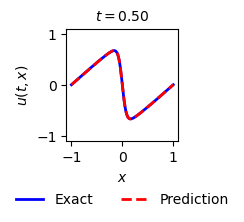

In [85]:
# u(t,x) slices

gs1 = gridspec.GridSpec(1, 1)
gs1.update(top=1 - 1.0 / 3.0 - 0.1,
           bottom=1.0 - 2.0 / 3.0,
           left=0.1,
           right=0.9,
           wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[50, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=10)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.35),
          ncol=5,
          frameon=False)

plt.show()

<hr style="height:10px;border-width:0;background-color:blue">

### 256x128

In [86]:
nu = 0.1/np.pi  # viscosity
N_u = 2000  # nro of CPs
layers = [2, 20, 20, 20, 1]  # achitecture
# datafile = '../data/burgers_shock.mat'
data = np.load('../data/burgers256x128-02.npz')

## Main

In [87]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

## Model

In [88]:
%%time
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1

e_576/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_577/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_578/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_579/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_580/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_581/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_582/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_583/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_584/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_585/shape: (Const): /job:localhost

## Train

Computing-intensive part

In [89]:
%%time
model.train(0)

L-BFGS-B optimizer run.
CPU times: user 1min 4s, sys: 3.43 s, total: 1min 8s
Wall time: 39.6 s


## Predict

In [90]:
%%time
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

CPU times: user 990 ms, sys: 125 ms, total: 1.12 s
Wall time: 899 ms


### Show the identified PDE

In [91]:
lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

In [92]:
print(r'Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0')
print(r'Identified PDE: ',
      r'u_t + %.5f u u_x - %.7f u_{xx} = 0' % (lambda_1_value, lambda_2_value))

Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0
Identified PDE:  u_t + 0.99924 u u_x - 0.0318372 u_{xx} = 0


## Error

- Uses the L2 norm (Euclidean distance)
- errou_u = distance error relative to distance

In [93]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100
print('Error u: %e' % (error_u))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))

Error u: 8.455291e-04
Error l1: 0.07566%
Error l2: 0.01940%


## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


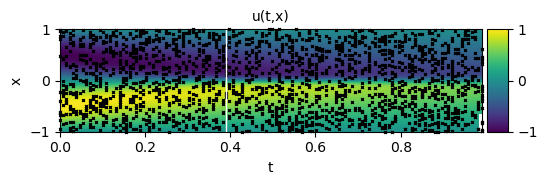

In [94]:
fig, ax = newfig(1.2, 1.2)
ax.axis('off')

# u(t,x)

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06,
           bottom=1 - 1.0 / 3.0 + 0.06,
           left=0.15,
           right=0.85,
           wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T,
              interpolation='nearest',
              cmap='viridis',
              extent=[t.min(), t.max(), x.min(),
                      x.max()],
              origin='lower',
              aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1],
        X_u_train[:, 0],
        'kx',
        #label='Data (%d points)' % (u_train.shape[0]),
        markersize=2,
        clip_on=False)

line = np.linspace(x.min(), x.max(), 2)[:, None]
#ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
#ax.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.0, -0.125),
          ncol=5,
          frameon=False)
ax.set_title('u(t,x)', fontsize=10)

plt.show()

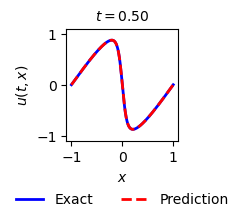

In [95]:
# u(t,x) slices

gs1 = gridspec.GridSpec(1, 1)
gs1.update(top=1 - 1.0 / 3.0 - 0.1,
           bottom=1.0 - 2.0 / 3.0,
           left=0.1,
           right=0.9,
           wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[50, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=10)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.35),
          ncol=5,
          frameon=False)

plt.show()

<hr style="height:10px;border-width:0;background-color:blue">

### 512x256

In [96]:
nu = 0.1/np.pi  # viscosity
N_u = 2000  # nro of CPs
layers = [2, 20, 20, 20, 1]  # achitecture
# datafile = '../data/burgers_shock.mat'
data = np.load('../data/burgers512x256-02.npz')

## Main

In [97]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

## Model

In [98]:
%%time
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1

evice:GPU:0
Reshape_812/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_813/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_814/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_815/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_816/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_817/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_818/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_819/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_820/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_821/shape: (Cons

## Train

Computing-intensive part

In [99]:
%%time
model.train(0)

L-BFGS-B optimizer run.
CPU times: user 1min 12s, sys: 3.87 s, total: 1min 15s
Wall time: 45.3 s


## Predict

In [100]:
%%time
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

CPU times: user 3.73 s, sys: 702 ms, total: 4.43 s
Wall time: 3.33 s


### Show the identified PDE

In [101]:
lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

In [102]:
print(r'Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0')
print(r'Identified PDE: ',
      r'u_t + %.5f u u_x - %.7f u_{xx} = 0' % (lambda_1_value, lambda_2_value))

Correct PDE   :  u_t + 1.0 u u_x - 0.0031831 u_{xx} = 0
Identified PDE:  u_t + 0.99936 u u_x - 0.0318292 u_{xx} = 0


## Error

- Uses the L2 norm (Euclidean distance)
- errou_u = distance error relative to distance

In [103]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100
print('Error u: %e' % (error_u))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))

Error u: 1.165230e-03
Error l1: 0.06448%
Error l2: 0.00551%


## Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


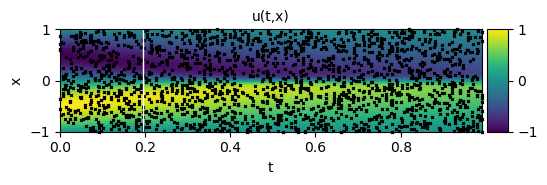

In [104]:
fig, ax = newfig(1.2, 1.2)
ax.axis('off')

# u(t,x)

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06,
           bottom=1 - 1.0 / 3.0 + 0.06,
           left=0.15,
           right=0.85,
           wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T,
              interpolation='nearest',
              cmap='viridis',
              extent=[t.min(), t.max(), x.min(),
                      x.max()],
              origin='lower',
              aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1],
        X_u_train[:, 0],
        'kx',
        #label='Data (%d points)' % (u_train.shape[0]),
        markersize=2,
        clip_on=False)

line = np.linspace(x.min(), x.max(), 2)[:, None]
#ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
#ax.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.0, -0.125),
          ncol=5,
          frameon=False)
ax.set_title('u(t,x)', fontsize=10)

plt.show()

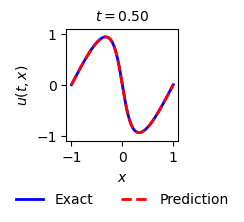

In [105]:
# u(t,x) slices

gs1 = gridspec.GridSpec(1, 1)
gs1.update(top=1 - 1.0 / 3.0 - 0.1,
           bottom=1.0 - 2.0 / 3.0,
           left=0.1,
           right=0.9,
           wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[50, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=10)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.35),
          ncol=5,
          frameon=False)

plt.show()

<hr style="height:10px;border-width:0;background-color:gray">

## Environment

In [75]:
%%bash
source $HOME/miniconda3/bin/activate tf1
conda list --explicit > Burgers-1D-Discovery-PINN-environment.txt